In [23]:
!pip install nibabel

You are using pip version 9.0.1, however version 22.0.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
# import packages 
import re
import random
import shutil
import numpy as np
import nibabel as nib 
from random import uniform
# from deepbrain import Extractor
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from skimage.transform import resize
from skimage.util import random_noise
from skimage.measure import label, regionprops
from scipy.ndimage.interpolation import rotate, map_coordinates
from scipy.ndimage.filters import gaussian_filter
from os import listdir, walk, remove    


In [25]:
# brain-cropping    
def crop(image):
    img_bo = image > 0
    img_labeled = label(img_bo)
    bounding_box = regionprops(img_labeled)
    # get the minimum and maximum valyues of x, y, z axis
    bb= bounding_box[0].bbox
    #print(len(bounding_box))
    #print(bb[0],bb[3],bb[1],bb[4],bb[2],bb[5])

    #crop the image along the x, yz and z axis
    img_crop= image[bb[0]:bb[3],
                  bb[1]:bb[4],
                  bb[2]:bb[5]]
    #print(img_crop.shape)
    return img_crop

# resize the images to (64,64,64)
def resizer(image, ideal_shape = (64, 64, 64)):
    # go along the x axis,resize images on the y and z axis
    img_new1 = np.zeros((image.shape[0],ideal_shape[1], ideal_shape[2]))
    for i in range(image.shape[0]):
        img = image[i,:,:]
        img_new1[i,:,:] = resize(img, (ideal_shape[1], ideal_shape[2]), anti_aliasing=True)
    
    # go along the y axis, resize images on the x and z axis
    img_new2 = np.zeros(ideal_shape)
    for i in range(img_new1.shape[1]):
        img = img_new1[:,i,:]
        img_new2[:,i,:] = resize(img, (ideal_shape[0], ideal_shape[2]), anti_aliasing=True)
    return img_new2

# intensity-nomalization
def scaler(image): 
    img_f = image.flatten()
    # find the range of the pixel values
    i_range = img_f[np.argmax(img_f)] - img_f[np.argmin(img_f)]
    # clear the minus pixel values in images
    image = image - img_f[np.argmin(img_f)]
    img_normalized = np.float32(image/i_range)
    #print(M_normalized.shape)
    return img_normalized 

# create a preprocessing procedure
def preprocessing_org(img_skull):
#     img_skull = skull_stripper(img)
    img_crop = crop(img_skull)
    img_std = resizer(img_crop)
    img_nor = scaler(img_std)
    return img_nor

In [26]:
#%%
# 3D visualize the MRI images in axonal plane
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def multi_slice_viewer(volume, extent):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index], extent = extent, cmap="gray")
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    
def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])   
    

#%%
# show class label distribution
def showpercentage(alist):
    array = np.unique(alist, return_counts=True)
    pad = array[1][0]/np.sum(array[1])
    pcn = array[1][1]/np.sum(array[1])
    pmci = array[1][2]/np.sum(array[1])
    print(str(pad) + " percent of the data has AD label")
    print(str(pcn) + " percent of the data has CN label")
    print(str(pmci) + " percent of the data has MCI label")

#%%
# show class label distribution
def showp2(alist):
    array = np.unique(alist, return_counts=True)
    pcn = array[1][0]/np.sum(array[1])
    pmci = array[1][1]/np.sum(array[1])
    pad = array[1][2]/np.sum(array[1])
    print(str(pad) + " percent of the data has AD label")
    print(str(pcn) + " percent of the data has CN label")
    print(str(pmci) + " percent of the data has MCI label")   

In [27]:
import os
import re
import numpy as np
import pandas as pd
import nibabel as nib 
import matplotlib.pyplot as plt
from os import getcwd, chdir, listdir, remove, walk
from sklearn.model_selection import train_test_split

In [30]:
counter = 0
root='data/sMCI'
processed = "preprocess/processed"
for name in listdir(root):
    file_path = root + "/" + name
    nii_img = nib.load(file_path)
    data = nii_img.get_data()
    img = np.asarray(data)
    processed_img = preprocessing_org(img)
    counter += 1
    new_name = name.replace(".nii", "")
#     print(file_path)
#     print(processed_img.shape)
#     print(new_name)
    np.save(processed + '/' +"sMCI_"+ new_name + "_processed", processed_img)
    print(str(counter) + " images have been processed")
#     break


/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys
/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1 images have been processed
2 images have been processed
3 images have been processed
4 images have been processed
5 images have been processed
6 images have been processed
7 images have been processed
8 images have been processed
9 images have been processed
10 images have been processed
11 images have been processed
12 images have been processed
13 images have been processed
14 images have been processed
15 images have been processed
16 images have been processed
17 images have been processed
18 images have been processed
19 images have been processed
20 images have been processed
21 images have been processed
22 images have been processed
23 images have been processed
24 images have been processed
25 images have been processed
26 images have been processed
27 images have been processed
28 images have been processed
29 images have been processed
30 images have been processed
31 images have been processed
32 images have been processed
33 images have been processed
34 images have been

In [31]:
len(listdir('preprocess/processed'))

919

preprocess/processed/sMCI_ADNI_029_S_2376_MR_Spatially_Normalized,_Masked_and_N3_corrected_T1_image_Br_20131104153835158_S195479_I397043_processed.npy


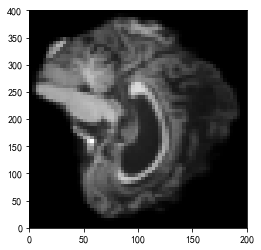

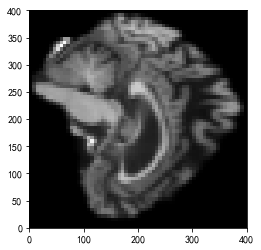

In [39]:
# check the processed images
img_check = np.load(processed + "/" + listdir(processed)[700])
print(processed + "/" + listdir(processed)[700])

# view the processed brain in 2D & 3D plottings
plt.imshow(img_check[30], aspect=0.5, extent = [0, 200, 0, 400], cmap = "gray")
multi_slice_viewer(img_check, [0, 400, 0, 400])

In [40]:
processed='preprocess/processed'
data = []
labels_img=[]
for name in listdir(processed):
    file_path = processed + "/" + name
    if name[-4:]==".npy":
        img = np.load(file_path)
#         print(img.shape)
        l=name.split("_")[0]
        data.append(img)
        if l=="NC":
            labels_img.append(0)
        if l=="pMCI":
            labels_img.append(1)
        if l=="AD":
            labels_img.append(2)
        if l=="sMCI":
            labels_img.append(3)
    



In [41]:
# split all images randomly into training/validation/testing       
trainval_rs, test_rs, trainval_y_rs, test_y_rs = train_test_split(data, labels_img, stratify = labels_img, test_size = 0.16, random_state = 87)
train_rs, val_rs, train_y_rs, val_y_rs = train_test_split(trainval_rs, trainval_y_rs, stratify = trainval_y_rs, test_size = 0.20, random_state = 87)

In [42]:
len(val_rs)

155

In [43]:
# define a path to store the randomly split input
input_path2 = "preprocess/input2/random_split/"

# save
np.save(input_path2 + "train_data", np.asarray(train_rs))
np.save(input_path2 + "train_label", np.asarray(train_y_rs))
np.save(input_path2 + "val_data", np.asarray(val_rs))
np.save(input_path2 + "val_label", np.asarray(val_y_rs))
np.save(input_path2 + "test_data", np.asarray(test_rs))
np.save(input_path2 + "test_label", np.asarray(test_y_rs))

In [19]:
# import numpy as np
# a=np.array([0,1,2,3,0,0,1,1])
# a1=np.where(a!=2 )[0]
# a2=np.where(a!=3 )[0]
# np.intersect1d(a1,a2)